# Imports

In [1]:
import numpy as np
import tensorflow as tf
from common.model import create_ssm, get_ssm_weights, set_ssm_weights
from common.data import generate_inputs, create_one_hot_array
from common.train import train

np.set_printoptions(linewidth=200)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0:1], 'GPU')

2025-02-01 16:39:01.575606: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-02-01 16:39:05.979181: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-02-01 16:39:05.981107: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-02-01 16:39:06.040303: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2025-02-01 16:39:06.041047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3e:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573

# Global variables

In [2]:
sd_baseline = 1
sd_special = 1
epochs = int(1e6)
log_period = 100
print_period = int(1e4)
n_evals = 7
epochs_after_opt = 5000
exper_type = 'dynamics'
adaptive = True

# Length = 6, teacher state dim = 1, student state dim = 10, seed = 105

## Shared setup

In [3]:
seed = 105
teacher_state_dim = 1
student_state_dim = 10
sd_A = 0.01
sd_B_C = 0.01
length = 6
ext_length = 40
n_baseline = 8
n_special = 10
eps = 0.01
diff = 0.05 / np.exp(20 * np.log10(1 / sd_A))

In [4]:
teacher, _ = create_ssm(teacher_state_dim, length, seed, 1, 1, 0)
A = np.zeros((teacher_state_dim, teacher_state_dim))
B = np.zeros((1, teacher_state_dim))
C = np.zeros((teacher_state_dim, 1))
A[0, 0] = 1
B[0, 0] = 1
C[0, 0] = 1
set_ssm_weights(teacher, [A, B, C])
ext_teacher, _ = create_ssm(teacher_state_dim, ext_length, seed, 1, 1, 0)
set_ssm_weights(ext_teacher, get_ssm_weights(teacher))

2025-02-01 16:39:06.099043: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-01 16:39:06.101170: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-02-01 16:39:06.102045: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2025-02-01 16:39:06.102119: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-02-01 16:39:06.102161: I tensorflow/stream_executor/

## 8 baseline inputs, 0 special inputs

In [5]:
base_lr = 0.01
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:2, :] = 1
title = 'SSM,\nwithout special sequences'

In [6]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

2025-02-01 16:39:07.244469: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


2025-02-01 16:39:07.757012: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-02-01 16:39:07.780052: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 3.0295586585998535
7 absolute largest EVs of A: [0.03153432 0.0315339  0.01101801 0.00863898 0.00862912 0.00680719 0.00501502]
-------------------------------------------------------
-------------------------------------------------------
Epoch: 10000
Train loss: 3.0295586585998535
7 absolute largest EVs of A: [0.06043633 0.03779568 0.01120351 0.00871856 0.00863422 0.00682334 0.00501575]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.009956598281860352
7 absolute largest EVs of A: [1.1527418  0.03854054 0.01121102 0.00872158 0.00863422 0.00682393 0.00501575]
+-------------+
|Final results|
+-------------+
Train loss: 0.0004100344958715141
7 absolute largest EVs of A: [9.9

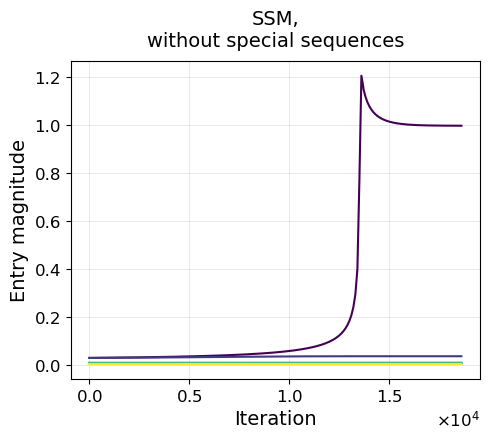

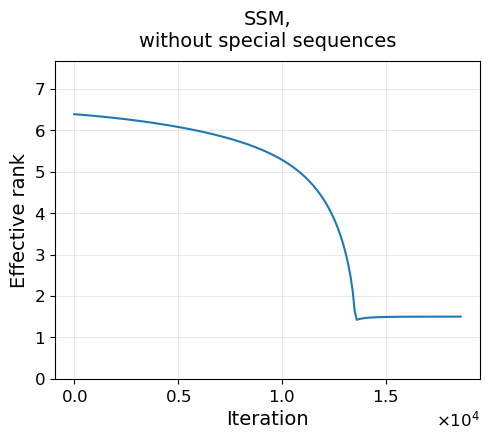

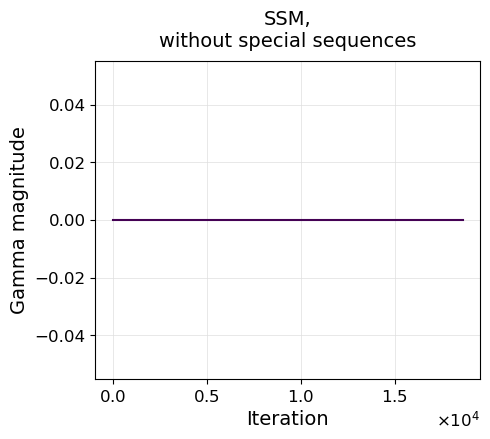

In [7]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=adaptive, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type=exper_type, title=title)

## 8 baseline inputs, 10 special inputs

In [8]:
base_lr = 0.01
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:2, :] = 1
special_input = np.zeros((n_special, length, 1))
special_input[:, length-2:length, :] = 1
title = 'SSM,\nwith special sequences'

In [9]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input, 
                               special_input=special_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 2.781104803085327
7 absolute largest EVs of A: [0.03153736 0.03153525 0.01102176 0.00864239 0.00862934 0.00680863 0.00501537]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.009919295087456703
7 absolute largest EVs of A: [1.0882952  0.5312806  0.43466774 0.3416838  0.22080678 0.03402893 0.03173541]
+-------------+
|Final results|
+-------------+
Train loss: 7.5599251431413e-05
7 absolute largest EVs of A: [1.0121175e+00 7.9675198e-01 5.9167510e-01 4.2291516e-01 2.5699246e-01 3.6670715e-02 3.3829555e-02 2.9720446e-02 1.8267700e-02 8.8928155e-06]
------------------------------------------------------------------------------------------------------
--------------------------

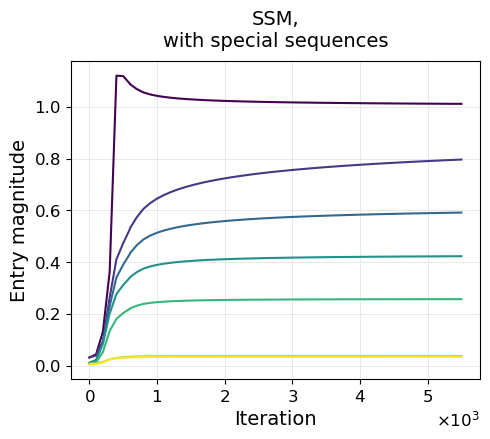

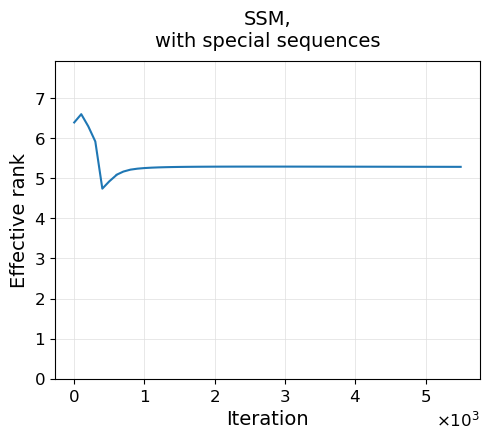

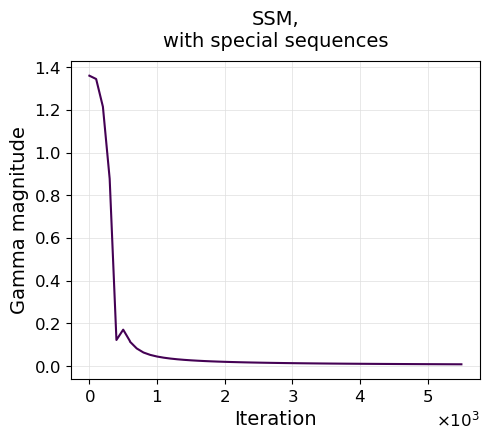

In [10]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=adaptive, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type=exper_type, title=title)

# Length = 10, teacher state dim = 1, student state dim = 20, seed = 4000

## Shared setup

In [11]:
seed = 4000
teacher_state_dim = 1
student_state_dim = 20
sd_A = 0.001
sd_B_C = 0.05
length = 10
ext_length = 40
n_baseline = 8
n_special = 10
eps = 0.05
diff = 0.05 / np.exp(20 * np.log10(1 / sd_A))

In [12]:
teacher, _ = create_ssm(teacher_state_dim, length, seed, 1, 1, 0)
A = np.zeros((teacher_state_dim, teacher_state_dim))
B = np.zeros((1, teacher_state_dim))
C = np.zeros((teacher_state_dim, 1))
A[0, 0] = 1
B[0, 0] = 1
C[0, 0] = 1
set_ssm_weights(teacher, [A, B, C])
ext_teacher, _ = create_ssm(teacher_state_dim, ext_length, seed, 1, 1, 0)
set_ssm_weights(ext_teacher, get_ssm_weights(teacher))

## 8 baseline inputs, 0 special inputs

In [13]:
base_lr = 0.01
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:length-3, :] = 1
title = 'SSM,\nwithout special sequences'

In [14]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 8.140823364257812
7 absolute largest EVs of A: [0.00173725 0.00173641 0.00153514 0.00150913 0.00143406 0.00141695 0.00131333]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.06669049710035324
7 absolute largest EVs of A: [1.0013583  0.0055089  0.00329825 0.00279676 0.00183557 0.00151074 0.00140357]
+-------------+
|Final results|
+-------------+
Train loss: 0.05953172594308853
7 absolute largest EVs of A: [9.8581904e-01 5.5088960e-03 3.2982733e-03 2.7967764e-03 1.8355723e-03 1.5107356e-03 1.4035715e-03 1.0013398e-03 9.9955231e-04 9.9603250e-04 8.6703629e-04 6.2150555e-04 6.1590649e-04 3.9591579e-04
 3.1509087e-04 2.8977980e-04 2.1634653e-04 1.8164776e-04 1.8008234e-04 1.07

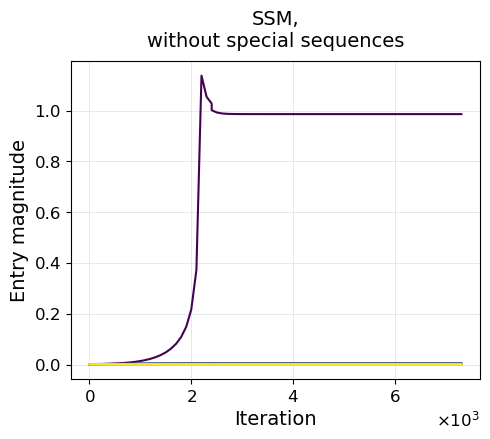

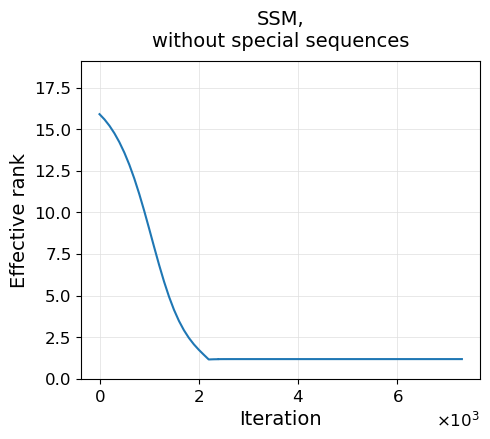

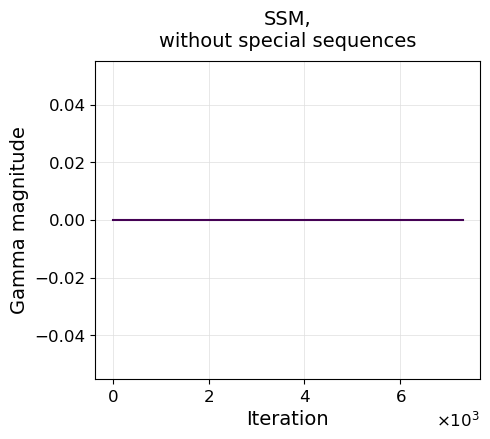

In [15]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=adaptive, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type=exper_type, title=title)

## 8 baseline inputs, 10 special inputs

In [16]:
base_lr = 0.01
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:length-3, :] = 1
special_input = np.zeros((n_special, length, 1))
special_input[:, length-2:length, :] = 1
title = 'SSM,\nwith special sequences'

In [17]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input, 
                               special_input=special_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 5.419342994689941
7 absolute largest EVs of A: [0.00193422 0.001874   0.00165706 0.00153908 0.00150937 0.00148754 0.00133052]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.050220929086208344
7 absolute largest EVs of A: [1.0362905  0.42477357 0.2290468  0.22870743 0.19457021 0.09939666 0.08920855]
+-------------+
|Final results|
+-------------+
Train loss: 0.005236316006630659
7 absolute largest EVs of A: [9.9701041e-01 4.9336240e-01 2.4220762e-01 2.4183626e-01 2.0398775e-01 1.0284609e-01 9.2278145e-02 8.6799853e-02 5.1975884e-02 3.6065552e-02 2.2548709e-02 2.0416565e-02 1.9827683e-02 1.7422276e-02
 5.5801696e-03 5.1830066e-03 4.8603071e-03 4.4836337e-03 1.3899878e-03 8.

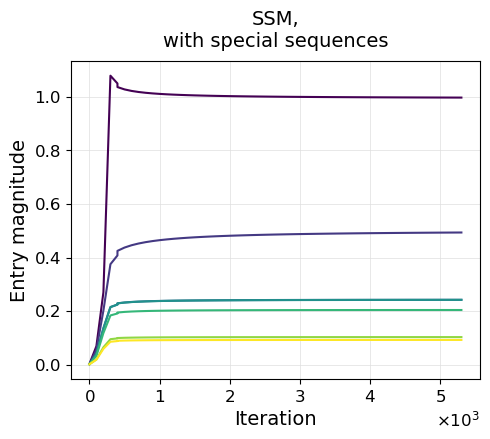

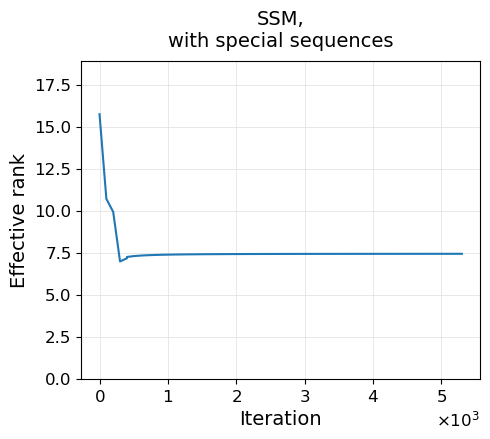

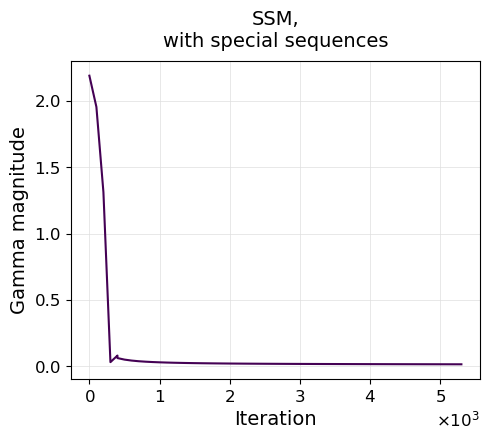

In [18]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=adaptive, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type=exper_type, title=title)

# Length = 6, teacher state dim = 1, student state dim = 10, seed = 100

## Shared setup

In [19]:
seed = 100
teacher_state_dim = 1
student_state_dim = 10
sd_A = 0.01
sd_B_C = 0.01
length = 6
ext_length = 40
n_baseline = 8
n_special = 10
eps = 0.01
diff = 0.05 / np.exp(20 * np.log10(1 / sd_A))

In [20]:
teacher, _ = create_ssm(teacher_state_dim, length, seed, 1, 1, 0)
A = np.zeros((teacher_state_dim, teacher_state_dim))
B = np.zeros((1, teacher_state_dim))
C = np.zeros((teacher_state_dim, 1))
A[0, 0] = 1
B[0, 0] = 1
C[0, 0] = 1
set_ssm_weights(teacher, [A, B, C])
ext_teacher, _ = create_ssm(teacher_state_dim, ext_length, seed, 1, 1, 0)
set_ssm_weights(ext_teacher, get_ssm_weights(teacher))

## 8 baseline inputs, 0 special inputs

In [21]:
base_lr = 0.01
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:2, :] = 1
title = 'SSM,\nwithout special sequences'

In [22]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.7662966251373291
7 absolute largest EVs of A: [0.02203692 0.02203679 0.00860916 0.00564485 0.00351127 0.00336591 0.0026922 ]
-------------------------------------------------------
-------------------------------------------------------
Epoch: 10000
Train loss: 0.7662966251373291
7 absolute largest EVs of A: [0.02624009 0.02439756 0.00871281 0.00570717 0.00352017 0.00336923 0.0026922 ]
-------------------------------------------------------
-------------------------------------------------------
Epoch: 20000
Train loss: 0.7662966251373291
7 absolute largest EVs of A: [0.03318956 0.02721084 0.00878796 0.00575184 0.00352644 0.00337155 0.0026922 ]
-------------------------------------------------------
-------------------------------------------------------
Epoch: 30000
Train loss: 0.7662966251373291
7 absolute largest EVs of A: [0.04778268 0.02986585 0.00

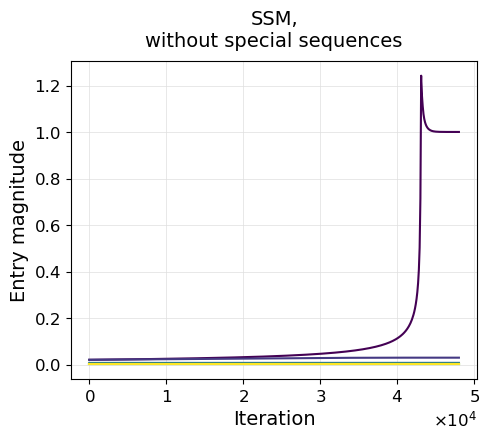

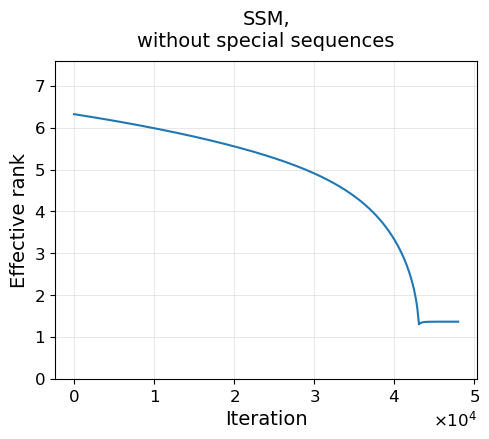

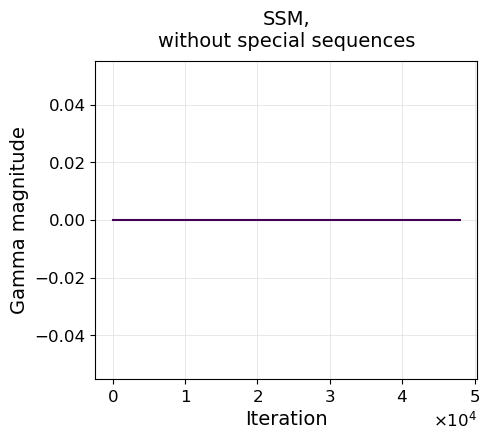

In [23]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=adaptive, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type=exper_type, title=title)

## 8 baseline inputs, 10 special inputs

In [24]:
base_lr = 0.01
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:2, :] = 1
special_input = np.zeros((n_special, length, 1))
special_input[:, length-2:length, :] = 1
title = 'SSM,\nwith special sequences'

In [25]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input, 
                               special_input=special_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 1.5129318237304688
7 absolute largest EVs of A: [0.02204286 0.02204045 0.00861304 0.00565327 0.00351646 0.00336816 0.00269322]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.00993458740413189
7 absolute largest EVs of A: [1.1295401  0.5968549  0.35234752 0.32385895 0.25692198 0.21760724 0.11814059]
+-------------+
|Final results|
+-------------+
Train loss: 5.531843726203078e-06
7 absolute largest EVs of A: [1.0087175  0.9632088  0.46109164 0.41788766 0.3140515  0.26066792 0.13467346 0.11019035 0.06580332 0.01181679]
------------------------------------------------------------------------------------------------------
------------------------------------------------------

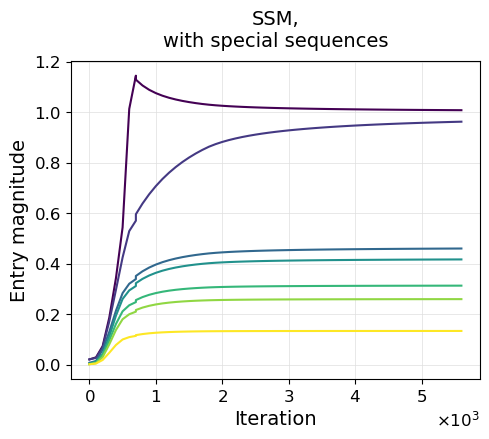

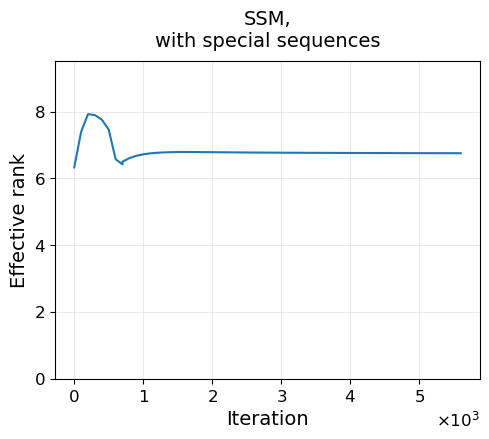

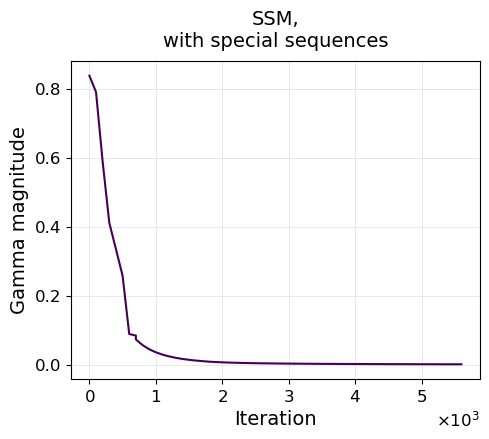

In [26]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=adaptive, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type=exper_type, title=title)

# Length = 10, teacher state dim = 1, student state dim = 20, seed = 4001

## Shared setup

In [27]:
seed = 4001
teacher_state_dim = 1
student_state_dim = 20
sd_A = 0.001
sd_B_C = 0.05
length = 10
ext_length = 40
n_baseline = 8
n_special = 10
eps = 0.05
diff = 0.05 / np.exp(20 * np.log10(1 / sd_A))

In [28]:
teacher, _ = create_ssm(teacher_state_dim, length, seed, 1, 1, 0)
A = np.zeros((teacher_state_dim, teacher_state_dim))
B = np.zeros((1, teacher_state_dim))
C = np.zeros((teacher_state_dim, 1))
A[0, 0] = 1
B[0, 0] = 1
C[0, 0] = 1
set_ssm_weights(teacher, [A, B, C])
ext_teacher, _ = create_ssm(teacher_state_dim, ext_length, seed, 1, 1, 0)
set_ssm_weights(ext_teacher, get_ssm_weights(teacher))

## 8 baseline inputs, 0 special inputs

In [29]:
base_lr = 0.01
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:length-3, :] = 1
title = 'SSM,\nwithout special sequences'

In [30]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 4.460504531860352
7 absolute largest EVs of A: [0.00200143 0.00200052 0.00139035 0.00107339 0.0008126  0.00073723 0.0006986 ]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.05630185082554817
7 absolute largest EVs of A: [1.0162895e+00 2.7162579e-03 2.5885648e-03 1.3004695e-03 8.8810787e-04 8.5049478e-04 7.4011111e-04]
+-------------+
|Final results|
+-------------+
Train loss: 0.03050035797059536
7 absolute largest EVs of A: [9.8906857e-01 2.7162579e-03 2.5885648e-03 1.3004695e-03 8.8810787e-04 8.5049478e-04 7.4011111e-04 5.4658792e-04 4.8324719e-04 4.6798002e-04 4.3214380e-04 3.3984505e-04 3.1147746e-04 2.5317547e-04
 2.5162401e-04 2.0046197e-04 1.6232926e-04 1.4552352e-

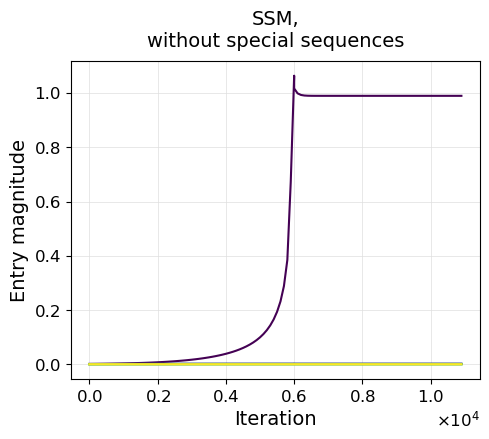

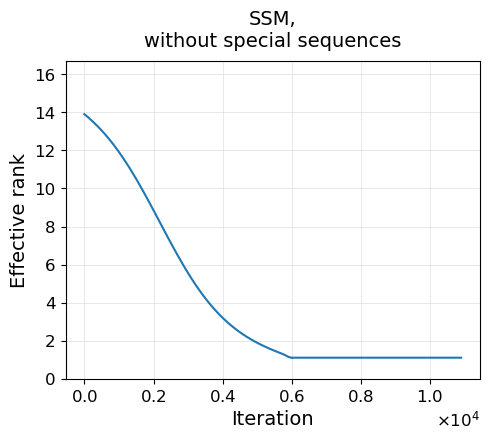

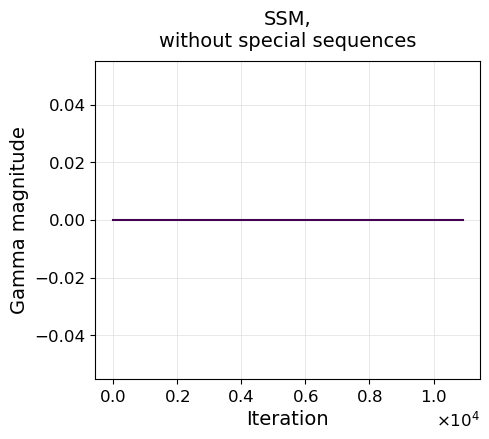

In [31]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=adaptive, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type=exper_type, title=title)

## 8 baseline inputs, 10 special inputs

In [32]:
base_lr = 0.01
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:length-3, :] = 1
special_input = np.zeros((n_special, length, 1))
special_input[:, length-2:length, :] = 1
title = 'SSM,\nwith special sequences'

In [33]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input, 
                               special_input=special_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 3.2063777446746826
7 absolute largest EVs of A: [0.00209316 0.00202195 0.00145718 0.00110444 0.0008326  0.00077177 0.00071395]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.04954163730144501
7 absolute largest EVs of A: [1.0389562  0.58222294 0.38782457 0.20711896 0.14469895 0.09532247 0.09356434]
+-------------+
|Final results|
+-------------+
Train loss: 0.0021790156606584787
7 absolute largest EVs of A: [1.0005022  0.8683534  0.43293387 0.21891394 0.15109198 0.0992296  0.09729242 0.06629489 0.06615718 0.04542679 0.04396676 0.03642556 0.03484477 0.02755187 0.01949854 0.01935464 0.00950216 0.00430029
 0.00250418 0.00133657]
----------------------------------------------

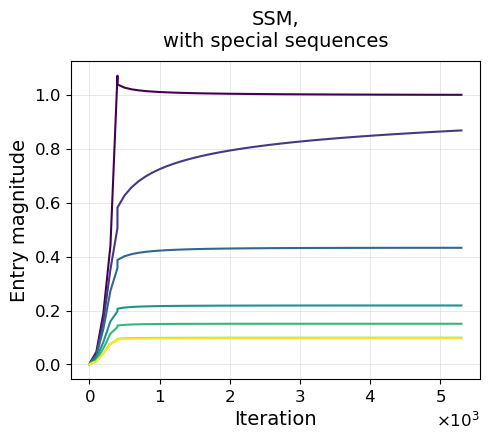

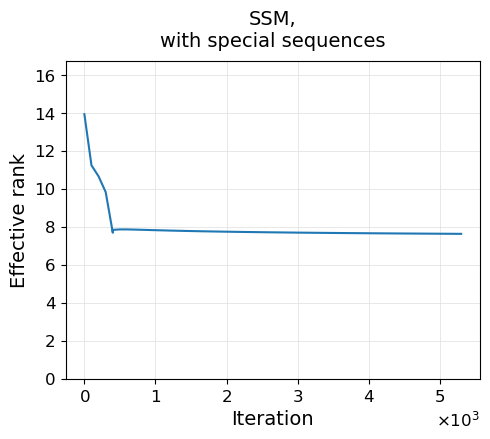

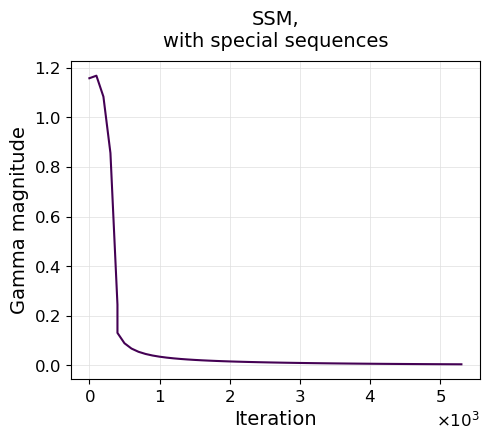

In [34]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=adaptive, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type=exper_type, title=title)